# Отчет по Лабоработной работе №3

## Результаты определения параметров кэш-памяти

Описание процессора моего ноутбука [с сайта cpu-world.com](http://www.cpu-world.com/CPUs/Core_i5/Intel-Core%20i5-4258U%20Mobile%20processor.html):
* **Level 1 cache size:**
    * 2 x 32 KB 8-way set associative instruction caches
    * 2 x 32 KB 8-way set associative data caches
* **Level 2 cache size:**
    * 2 x 256 KB 8-way set associative caches
* **Level 3 cache size:**
    * 3 MB 12-way set associative shared cache
* **Data width:**	
    * 64 bit
* **The number of cores:**	
    * 2

Часть параметров можно получить при помощи системной утилиты `sysctl`:
```
$> sysctl -a | grep machdep.cpu.cache
machdep.cpu.cache.linesize: 64
machdep.cpu.cache.L2_associativity: 8
machdep.cpu.cache.size: 256
```

Получаем конфигурацию:

* 2 CPU
* `CacheLine = 64b = 2^6`
* `L1 = 32KB, 8-way, per-cpu`
* `L2 = 256KB, 8-way, per-cpu`
* `L3 = 3MB, 12-way, shared`

* `32Kb / 64b = 512 blocks`
* `512 / 8 = 2^6 =64 sets`

`64bit pointer = [52 bit - tag][6 bit - index][6 bit - offset]`

## Код анализа количества промахов

* Исходник без tooling-а и подсчета промахов - [main.cpp](main.cpp)
* Исходник c tooling-ом для подсчета промахов - [main_tooled.cpp](main_tooled.cpp)
* Скрипт сборки - [compile.sh](compile.sh)
    * Замечу, что для main.cpp использовалась сборка без оптимизаций, т.к. оптимизатор сильно _оптимизировал_ и обработка задачи любой размерности укладывалась в доли секунды. 
    * При использовании main.cpp без модификаций (с блочными реализациями), `-O2` такого трюка не проделывало.
* Скрипт запуска программы с tooling-ом - [run.sh](run.sh)
* Скрипт для запуска валгринда на программе без tooling-а - [valgrind.sh](valgrind.sh)

## Графики cache-miss-ов

Ниже мы считываем и парсим логи запусков программы с tooling-ом и программы по valgrind-ом.

In [59]:
%matplotlib inline
from matplotlib import pyplot

In [60]:
def prepare_stats(path='compact_report_stats.txt'):
    graph = dict()
    curStats = list()
    for line in open(path):
        k,v = map(str.strip, line.strip().split('='))
        if k == 'n':
            curStats = dict()
            graph.setdefault(int(v), list()).append(curStats)
        else:
            if not '.' in v:
                v = int(v)
            elif v[-1] == '%':
                v = float(v[:-1]) / 100.0
            else:
                v = float(v)
            curStats[k] = v
    return graph
stats = prepare_stats()

In [61]:
def build_graphs(stats):
    graphs = dict() # cache_lvl -> {param -> [(size,val),..]}
    for size, stat in stats.iteritems():
        for lvl, perLvlStat in enumerate(stat):
            for param, val in perLvlStat.iteritems():
                graphs.setdefault(lvl, dict()).setdefault(param, list()).append((size, val))
    return graphs
graphs = build_graphs(stats)

In [62]:
def draw_graphs(graphs, figsize):
    fig = pyplot.figure(figsize=figsize)
    col_count = len(graphs)
    for col_num, (lvl, perParamGraph) in enumerate(graphs.iteritems()):
        row_count = len(perParamGraph)
        for row_num, (param, graph) in enumerate(perParamGraph.iteritems()):
            graph.sort()
            ax = fig.add_subplot(row_count, col_count, 1 + col_num + col_count * row_num)
            ax.set_title('Cache lvl {} - {}'.format(lvl + 1, param))
            ax.plot([_[0] for _ in graph], [_[1] for _ in graph], color='blue', linestyle='-', marker='o',
         markerfacecolor='green', markersize=12)
            ax.set_yscale('log')
    pyplot.show()

In [71]:
valgrind_data = dict()
size = 0
for line in open('valgrind.txt'):
    if 'n = ' in line:
        size = int(line.split('=')[1].strip())
    elif 'D1  misses' in line:
        valgrind_data.setdefault(0, dict()).setdefault('total', list()).append(
            (size, int(line.split(':')[1].split('(')[0].replace(',', '')))
        )
    elif 'LLd misses' in line:
        valgrind_data.setdefault(2, dict()).setdefault('total', list()).append(
            (size, int(line.split(':')[1].split('(')[0].replace(',', '')))
        )

### Графики по данным, полученным из main_tooled.cpp

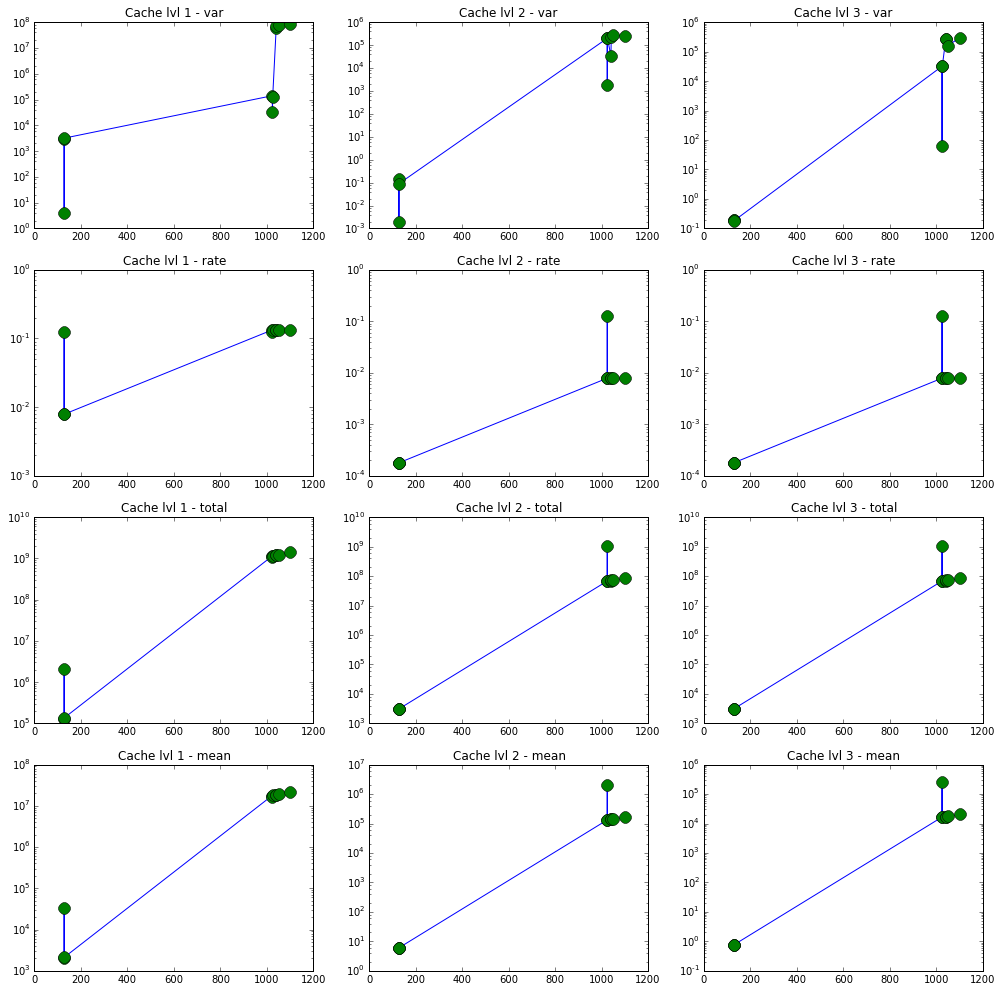

In [65]:
draw_graphs(graphs, figsize=(17, 17))

### Графики по данным, полученным из valgrind

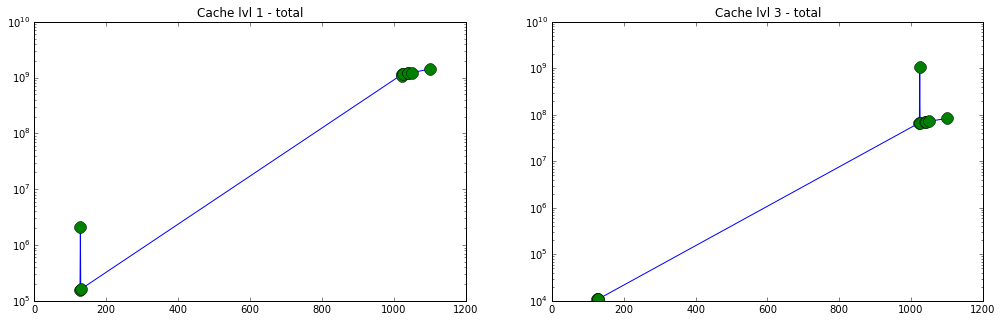

In [73]:
draw_graphs(valgrind_data, figsize=(17, 5))

### Описание графиков

#### Корректность измерений
* Как видно на графиках **Cache lvl n - total** для ручного подсчета и valgrind-a, они совпадают, так что подсчет в main_tooled.cpp можно считать корректным.

#### Анализ всплесков количества промахов при n = 128 и 1024
* На графиках **Cache lvl 2** и **3** виден скачек при `n = 1024`. Это происходит из-за того, что при проходе по столбцу в матрице **B** алгоритма перемножения матриц, адреса элементов каждого фиксированного столбца будут пытаться попасть в один и тот-же cache-set. Тем самым при проходе по столбцу, необходимые в следующем столбце данные будут с большей вероятностью вытесняться из кэша, чем, к примеру, при `n = 1023` или `n = 1025`. 
* На графиках для **Cache lvl 1** скачка `n = 1024` не видно, т.к. и при `n = 1023` и при `n = 1025` количество строк, которое нужно размазать по кэшу для последующего переиспользования кэш-линий при проходе по следующему столбцу, **больше** чем реальное количество места в кэше (для моего конкретного кэша доступно всего `64 set * 8 ways = 512` мест под кэш-линии, что меньше необходимых 1023, 1024 и 1025). 
* Для проверки этой гипотезы в тест были добавлены n = [127, 128, 129]. На них получается похожая с `n = 1024` ситуация - элементы одного столбца _размазываются_ не по всем cache-set-ам, а только по нескольким. Но т.к. 128 < 512, то на размерах отличных от 128 данные размазываются лучше, не вымываются __и__ их можно переиспользовать при следующем проходе по столбцу.